## CNN

In [1]:
import matplotlib.image as mpimg
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import os, sys, glob, re
from PIL import Image

import torch
import torch.nn as nn
from torch.nn.functional import *
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import *

import torchvision
import torchvision.transforms as T
from torchvision import models

#import segmentation_models_pytorch as smp
from tqdm import tqdm

C:\Users\valer\miniconda3\envs\ada\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\valer\miniconda3\envs\ada\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\valer\miniconda3\envs\ada\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
if torch.cuda.is_available():
    print("Name of the Graphics card", torch.cuda.get_device_name())
    print("Number of GPU available", torch.cuda.device_count())
    device = "cuda"
else:
    print("No GPU available on this machine")
    device = "cpu"

Name of the Graphics card NVIDIA GeForce RTX 2060
Number of GPU available 1


In [3]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, patch_size, padding):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    if is_2d:
        padding_channel = ((padding, padding), (padding, padding))
    else:
        padding_channel = ((padding, padding), (padding, padding), (0, 0))
    im = np.lib.pad(im, padding_channel, 'reflect')
    for i in range(padding, imgheight + padding, patch_size):
        for j in range(padding, imgwidth + padding, patch_size):
            if is_2d:
                im_patch = im[j - padding:j + patch_size + padding, i - padding:i + patch_size + padding]
            else:
                im_patch = im[j - padding:j + patch_size + padding, i - padding:i + patch_size + padding, :]
            list_patches.append(im_patch)
    return list_patches

def accuracy(predicted_logits, reference):
    """
    Compute the ratio of correctly predicted labels
    
    @param predicted_logits: float32 tensor of shape (batch size, num classes)
    @param reference: int64 tensor of shape (batch_size) with the class number
    """
    labels = torch.argmax(predicted_logits, 1)
    correct_predictions = labels.eq(reference)
    return correct_predictions.sum().float() / correct_predictions.nelement()

In [4]:
# Loaded a set of images
root_dir = "data/training/"
image_test = "data/test_set_images"
image_dir = root_dir + "images/"
files = os.listdir(image_dir)
#n = min(30, len(files))
n = len(files)
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png


Image size = 400,400


Text(0.5, 1.0, 'real and groundtruth images')

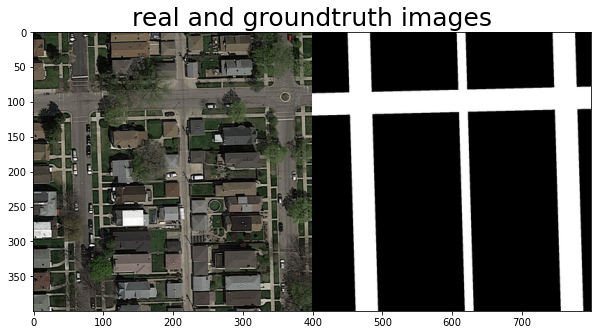

In [5]:
%matplotlib inline
i=5
print('Image size = ' + str(imgs[i].shape[0]) + ',' + str(imgs[i].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[i], gt_imgs[i])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')
plt.title("real and groundtruth images", fontdict={'fontsize':25})

In [6]:
# Extract patches from input images
patch_size = 16
window_size = 64
padding = (window_size - patch_size) // 2

img_patches = [img_crop(imgs[i], patch_size, padding) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, 0) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

# Mean and std of our dataset of image patches
mean_img = np.mean(img_patches, axis=(0, 1, 2))
std_img = np.std(img_patches, axis=(0, 1, 2))

In [7]:
# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat = np.append(feat_m, feat_v)
    return feat

# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, 0)
    X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
    return X 

#### Loading the training set

In [8]:
# Class describing the training dataset used by the CNN
class TrainsetCNN(Dataset):
    def __init__(self, x, y, augmentation=None):
        self.x = x
        self.y = torch.tensor(y).long()
        # Number of image patches in the dataset
        self.length = self.x.shape[0]
        # The way we normalize the image patches
        normalization = T.Normalize(mean_img, std_img)
        # The way we define data augmentation in our dataset
        if augmentation:
            self.augmentation = T.Compose([augmentation, normalization])
        else:
            self.augmentation = T.Compose([T.ToTensor(), normalization]) # No Data Augmentation

    def __getitem__(self, idx):
        return self.augmentation(self.x[idx]), self.y[idx]

    def __len__(self):
        return self.length



#### Training and Validation datasets

In [9]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

In [10]:
# the training set is imbalanced (too few roads)
def balanced_sampler (labels):
    # defining weights for the classes
    class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(labels), y = labels)
    print("Dealing with imbalanced datasets")
    print("Background weight: {:.3f}\nRoad weight: {:.3f}".format(class_weights[0], class_weights[1]))

    # Picking a road or a background patch with the same probability (=> balanced training set)
    weights = class_weights[labels]
    weights = torch.tensor(weights, dtype=torch.float32)
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
    return sampler

In [19]:
# Trainset and Validation sets
img_train, img_valid, Y_train, Y_valid = train_test_split(img_patches, Y, test_size=0.2)

batch_size = 200
sampler = balanced_sampler(Y_train)
dataset_train = DataLoader(TrainsetCNN(img_train, Y_train), batch_size=batch_size, sampler=sampler)
dataset_valid = DataLoader(TrainsetCNN(img_valid, Y_valid), batch_size=batch_size, shuffle=True)

print("Number of patches in the training dataset: {}".format(len(img_train)))
print("Number of patches in the validation dataset: {}".format(len(img_valid)))

Dealing with imbalanced datasets
Background weight: 0.674
Road weight: 1.935
Number of patches in the training dataset: 50000
Number of patches in the validation dataset: 12500


#### Training the CNN

In [12]:
class LeNetModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3)
        self.batch_norm3 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(9216 , 256) #9216 4096 
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)


    def forward(self, x):
        # Convolutional Layers
        x = self.batch_norm1(leaky_relu(max_pool2d(self.conv1(x), 2)))
        x = dropout(x, 0.2, training=self.training)
        x = self.batch_norm2(leaky_relu(max_pool2d(self.conv2(x), 2)))
        x = dropout(x, 0.2, training=self.training)
        x = self.batch_norm3(leaky_relu(max_pool2d(self.conv3(x), 2)))
        x = dropout(x, 0.2, training=self.training)

        x = x.view(x.shape[0], -1)
        # Fully Connected Layers
        x = leaky_relu(self.fc1(x))
        x = dropout(x, 0.2, training=self.training)
        x = leaky_relu(self.fc2(x))
        x = dropout(x, 0.2, training=self.training)
        x = leaky_relu(self.fc3(x))
        x = dropout(x, 0.2, training=self.training)
        x = softmax(x, dim=1)

        return x

In [13]:
def train(model, criterion, dataset_train, dataset_valid, optimizer, scheduler, num_epochs):
    """
    @param model: torch.nn.Module
    @param criterion: torch.nn.modules.loss._Loss
    @param dataset_train: torch.utils.data.DataLoader
    @param dataset_valid: torch.utils.data.DataLoader
    @param optimizer: torch.optim.Optimizer
    @param num_epochs: int
    """
    print("Starting training")

    loss_train = []
    loss_valid = []

    for epoch in range(num_epochs):
        # Train an epoch
        model.train()
        running_loss = 0.
        for batch_x, batch_y in tqdm(dataset_train):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Evaluate the network (forward pass)
            prediction = model(batch_x)
            loss = criterion(prediction, batch_y)
            running_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_train.append(running_loss / len(dataset_train))


        # Test the quality on the validation set
        model.eval()
        accuracies_valid = []
        f1_valid = []
        running_loss = 0.
        for batch_x, batch_y in dataset_valid:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            prediction = model(batch_x)
            loss = criterion(prediction, batch_y)
            running_loss += loss.item()

            accuracies_valid.append(accuracy(prediction, batch_y))
            aux = prediction.detach().cpu().argmax(1).numpy()
            f1_valid.append(f1_score(batch_y.cpu().detach(), aux))

        loss_valid.append(running_loss / len(dataset_valid))

        # Printing statistics
        accuracy_epoch = sum(accuracies_valid) / len(accuracies_valid)
        f1_epoch = sum(f1_valid) / len(f1_valid)
        print("Epoch {}".format(epoch + 1))
        print("val accuracy: {:.5f}, f1-score: {:.5f}\n".format(accuracy_epoch, f1_epoch))
        
        scheduler.step(f1_epoch)

    print("Finished")
    return loss_train, loss_valid

In [14]:
# hyperparameters
num_epochs = 200
learning_rate = 1e-3

# Criterion to optimize
criterion = torch.nn.CrossEntropyLoss()

In [15]:
## hyperparameters
#num_epochs = 10
#learning_rate = 1e-3

## Criterion to optimize
## the training set is imbalanced (too few roads) => defining weights for the classes
#class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(Y_train), y = Y_train)
#class_weights = torch.tensor(class_weights, dtype=torch.float32)
#criterion = torch.nn.CrossEntropyLoss(weight = class_weights)

#print("Dealing with imbalanced datasets")
#print("Background weight: {:.3f}\nRoad weight: {:.3f}".format(class_weights[0], class_weights[1]))

#### Performance of the Model without Data Augmentation

In [16]:
# plotting the loss curves for the train and the validation sets
def plot_performance (loss_train, loss_valid):
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, loss_train)
    plt.plot(epochs, loss_valid)
    plt.legend(["train loss", "validation loss"])
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.show()

Starting training


100%|████████████████████████████████████████| 250/250 [00:17<00:00, 14.41it/s]


Epoch 1
val accuracy: 0.75024, f1-score: 0.65013



100%|████████████████████████████████████████| 250/250 [00:14<00:00, 17.04it/s]


Epoch 2
val accuracy: 0.82262, f1-score: 0.69096



100%|████████████████████████████████████████| 250/250 [00:15<00:00, 16.26it/s]


Epoch 3
val accuracy: 0.81389, f1-score: 0.70497



100%|████████████████████████████████████████| 250/250 [00:15<00:00, 16.23it/s]


Epoch 4
val accuracy: 0.79270, f1-score: 0.69084



100%|████████████████████████████████████████| 250/250 [00:16<00:00, 14.90it/s]


Epoch 5
val accuracy: 0.83310, f1-score: 0.73455



100%|████████████████████████████████████████| 250/250 [00:16<00:00, 15.19it/s]


Epoch 6
val accuracy: 0.81444, f1-score: 0.55638



100%|████████████████████████████████████████| 250/250 [00:16<00:00, 15.42it/s]


Epoch 7
val accuracy: 0.76698, f1-score: 0.66894



100%|████████████████████████████████████████| 250/250 [00:16<00:00, 15.39it/s]


Epoch 8
val accuracy: 0.83579, f1-score: 0.73150



100%|████████████████████████████████████████| 250/250 [00:16<00:00, 15.29it/s]


Epoch 9
val accuracy: 0.85865, f1-score: 0.76930



100%|████████████████████████████████████████| 250/250 [00:16<00:00, 14.83it/s]


Epoch 10
val accuracy: 0.86222, f1-score: 0.75141



100%|████████████████████████████████████████| 250/250 [00:17<00:00, 14.01it/s]


Epoch 11
val accuracy: 0.84714, f1-score: 0.72591



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 13.12it/s]


Epoch 12
val accuracy: 0.84452, f1-score: 0.73465



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.04it/s]


Epoch 13
val accuracy: 0.87286, f1-score: 0.77965



100%|████████████████████████████████████████| 250/250 [00:23<00:00, 10.42it/s]


Epoch 14
val accuracy: 0.87143, f1-score: 0.77501



100%|████████████████████████████████████████| 250/250 [00:21<00:00, 11.61it/s]


Epoch 15
val accuracy: 0.86849, f1-score: 0.77655



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.61it/s]


Epoch 16
val accuracy: 0.86627, f1-score: 0.77933



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.58it/s]


Epoch 17
val accuracy: 0.84000, f1-score: 0.74722



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.60it/s]


Epoch 18
val accuracy: 0.86421, f1-score: 0.77355



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.47it/s]


Epoch 19
val accuracy: 0.82730, f1-score: 0.70653



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.50it/s]


Epoch 20
val accuracy: 0.88413, f1-score: 0.79266



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.44it/s]


Epoch 21
val accuracy: 0.82683, f1-score: 0.69968



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.52it/s]


Epoch 22
val accuracy: 0.85317, f1-score: 0.76823



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.53it/s]


Epoch 23
val accuracy: 0.83071, f1-score: 0.66031



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.45it/s]


Epoch 24
val accuracy: 0.84579, f1-score: 0.75601



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.47it/s]


Epoch 25
val accuracy: 0.88230, f1-score: 0.79233



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.60it/s]


Epoch 26
val accuracy: 0.87643, f1-score: 0.79433



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.57it/s]


Epoch 27
val accuracy: 0.87667, f1-score: 0.78237



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.54it/s]


Epoch 28
val accuracy: 0.89095, f1-score: 0.80994



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.53it/s]


Epoch 29
val accuracy: 0.89071, f1-score: 0.81331



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.56it/s]


Epoch 30
val accuracy: 0.87373, f1-score: 0.78988



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.56it/s]


Epoch 31
val accuracy: 0.88921, f1-score: 0.80814



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.51it/s]


Epoch 32
val accuracy: 0.89389, f1-score: 0.81503



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.47it/s]


Epoch 33
val accuracy: 0.88333, f1-score: 0.79588



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.54it/s]


Epoch 34
val accuracy: 0.90183, f1-score: 0.82267



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.56it/s]


Epoch 35
val accuracy: 0.89238, f1-score: 0.81507



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.57it/s]


Epoch 36
val accuracy: 0.88214, f1-score: 0.80206



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.56it/s]


Epoch 37
val accuracy: 0.89849, f1-score: 0.82074



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.55it/s]


Epoch 38
val accuracy: 0.89810, f1-score: 0.82133



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.57it/s]


Epoch 39
val accuracy: 0.89278, f1-score: 0.79080



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.51it/s]


Epoch 40
val accuracy: 0.89841, f1-score: 0.81372



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.55it/s]


Epoch 41
val accuracy: 0.88540, f1-score: 0.78222



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.61it/s]


Epoch 42
val accuracy: 0.90310, f1-score: 0.82610



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.64it/s]


Epoch 43
val accuracy: 0.88476, f1-score: 0.78053



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.65it/s]


Epoch 44
val accuracy: 0.89794, f1-score: 0.82614



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.66it/s]


Epoch 45
val accuracy: 0.90143, f1-score: 0.82846



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.70it/s]


Epoch 46
val accuracy: 0.90198, f1-score: 0.83162



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.67it/s]


Epoch 47
val accuracy: 0.90794, f1-score: 0.83944



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.64it/s]


Epoch 48
val accuracy: 0.88310, f1-score: 0.76278



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.65it/s]


Epoch 49
val accuracy: 0.87651, f1-score: 0.76841



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.27it/s]


Epoch 50
val accuracy: 0.88944, f1-score: 0.80883



100%|████████████████████████████████████████| 250/250 [00:24<00:00, 10.14it/s]


Epoch 51
val accuracy: 0.84778, f1-score: 0.66900



100%|████████████████████████████████████████| 250/250 [00:25<00:00,  9.81it/s]


Epoch 52
val accuracy: 0.90278, f1-score: 0.82474



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.51it/s]


Epoch 53
val accuracy: 0.91079, f1-score: 0.84112



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.57it/s]


Epoch 54
val accuracy: 0.90595, f1-score: 0.83171



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.51it/s]


Epoch 55
val accuracy: 0.91032, f1-score: 0.84154



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.50it/s]


Epoch 56
val accuracy: 0.91111, f1-score: 0.84145



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.61it/s]


Epoch 57
val accuracy: 0.90706, f1-score: 0.82855



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.64it/s]


Epoch 58
val accuracy: 0.89921, f1-score: 0.82594



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.41it/s]


Epoch 59
val accuracy: 0.91436, f1-score: 0.84283



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.33it/s]


Epoch 60
val accuracy: 0.89778, f1-score: 0.82557



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.60it/s]


Epoch 61
val accuracy: 0.90111, f1-score: 0.81697



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.63it/s]


Epoch 62
val accuracy: 0.92230, f1-score: 0.85073



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.62it/s]


Epoch 63
val accuracy: 0.92048, f1-score: 0.85392



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.42it/s]


Epoch 64
val accuracy: 0.90262, f1-score: 0.83099



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.53it/s]


Epoch 65
val accuracy: 0.92040, f1-score: 0.85873



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.46it/s]


Epoch 66
val accuracy: 0.89944, f1-score: 0.81443



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.47it/s]


Epoch 67
val accuracy: 0.91310, f1-score: 0.84260



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.50it/s]


Epoch 68
val accuracy: 0.87103, f1-score: 0.72755



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.48it/s]


Epoch 69
val accuracy: 0.91238, f1-score: 0.84484



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.48it/s]


Epoch 70
val accuracy: 0.92143, f1-score: 0.85771



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.50it/s]


Epoch 71
val accuracy: 0.91595, f1-score: 0.85084



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.50it/s]


Epoch 72
val accuracy: 0.92206, f1-score: 0.85504



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.52it/s]


Epoch 73
val accuracy: 0.91373, f1-score: 0.84983



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.51it/s]


Epoch 74
val accuracy: 0.91611, f1-score: 0.84996



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.49it/s]


Epoch 75
val accuracy: 0.90810, f1-score: 0.83372



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.51it/s]


Epoch 76
val accuracy: 0.91643, f1-score: 0.84678



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.47it/s]


Epoch 77
val accuracy: 0.92143, f1-score: 0.85624



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.34it/s]


Epoch 78
val accuracy: 0.92167, f1-score: 0.85803



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.49it/s]


Epoch 79
val accuracy: 0.92389, f1-score: 0.86151



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.66it/s]


Epoch 80
val accuracy: 0.92429, f1-score: 0.86314



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.61it/s]


Epoch 81
val accuracy: 0.92397, f1-score: 0.86244



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.61it/s]


Epoch 82
val accuracy: 0.92579, f1-score: 0.86621



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.61it/s]


Epoch 83
val accuracy: 0.92754, f1-score: 0.86763



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.65it/s]


Epoch 84
val accuracy: 0.92817, f1-score: 0.86903



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.70it/s]


Epoch 85
val accuracy: 0.92857, f1-score: 0.87054



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.64it/s]


Epoch 86
val accuracy: 0.92968, f1-score: 0.87192



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.67it/s]


Epoch 87
val accuracy: 0.92865, f1-score: 0.87188



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.63it/s]


Epoch 88
val accuracy: 0.93008, f1-score: 0.87166



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.63it/s]


Epoch 89
val accuracy: 0.93095, f1-score: 0.87337



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.64it/s]


Epoch 90
val accuracy: 0.93167, f1-score: 0.87503



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.65it/s]


Epoch 91
val accuracy: 0.93206, f1-score: 0.87594



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.62it/s]


Epoch 92
val accuracy: 0.93063, f1-score: 0.87442



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.22it/s]


Epoch 93
val accuracy: 0.93040, f1-score: 0.87377



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.68it/s]


Epoch 94
val accuracy: 0.93222, f1-score: 0.87647



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.67it/s]


Epoch 95
val accuracy: 0.93159, f1-score: 0.87519



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.61it/s]


Epoch 96
val accuracy: 0.93317, f1-score: 0.87788



100%|████████████████████████████████████████| 250/250 [00:24<00:00, 10.18it/s]


Epoch 97
val accuracy: 0.93310, f1-score: 0.87717



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.63it/s]


Epoch 98
val accuracy: 0.93270, f1-score: 0.87658



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.61it/s]


Epoch 99
val accuracy: 0.93405, f1-score: 0.87912



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.57it/s]


Epoch 100
val accuracy: 0.93397, f1-score: 0.87962



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.35it/s]


Epoch 101
val accuracy: 0.93222, f1-score: 0.87524



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.50it/s]


Epoch 102
val accuracy: 0.93444, f1-score: 0.87789



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.56it/s]


Epoch 103
val accuracy: 0.93484, f1-score: 0.87952



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.57it/s]


Epoch 104
val accuracy: 0.93492, f1-score: 0.88070



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.58it/s]


Epoch 105
val accuracy: 0.93524, f1-score: 0.88110



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.58it/s]


Epoch 106
val accuracy: 0.93651, f1-score: 0.88219



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.55it/s]


Epoch 107
val accuracy: 0.93714, f1-score: 0.88354



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.57it/s]


Epoch 108
val accuracy: 0.93635, f1-score: 0.88321



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.54it/s]


Epoch 109
val accuracy: 0.93540, f1-score: 0.88170



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.54it/s]


Epoch 110
val accuracy: 0.93381, f1-score: 0.87909



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.54it/s]


Epoch 111
val accuracy: 0.93421, f1-score: 0.87897



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.54it/s]


Epoch 112
val accuracy: 0.93619, f1-score: 0.88085



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.54it/s]


Epoch 113
val accuracy: 0.93690, f1-score: 0.88265



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.46it/s]


Epoch 114
val accuracy: 0.93627, f1-score: 0.88232



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.48it/s]


Epoch 115
val accuracy: 0.93738, f1-score: 0.88450



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.46it/s]


Epoch 116
val accuracy: 0.93683, f1-score: 0.88353



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.44it/s]


Epoch 117
val accuracy: 0.93690, f1-score: 0.88382



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.43it/s]


Epoch 118
val accuracy: 0.93762, f1-score: 0.88357



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.51it/s]


Epoch 119
val accuracy: 0.93778, f1-score: 0.88383



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.51it/s]


Epoch 120
val accuracy: 0.93421, f1-score: 0.88087



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.48it/s]


Epoch 121
val accuracy: 0.93746, f1-score: 0.88367



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.53it/s]


Epoch 122
val accuracy: 0.93722, f1-score: 0.88599



100%|████████████████████████████████████████| 250/250 [00:21<00:00, 11.80it/s]


Epoch 123
val accuracy: 0.93778, f1-score: 0.88449



100%|████████████████████████████████████████| 250/250 [00:22<00:00, 10.95it/s]


Epoch 124
val accuracy: 0.93873, f1-score: 0.88693



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.44it/s]


Epoch 125
val accuracy: 0.93897, f1-score: 0.88661



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.50it/s]


Epoch 126
val accuracy: 0.93881, f1-score: 0.88583



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.50it/s]


Epoch 127
val accuracy: 0.93960, f1-score: 0.88605



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.49it/s]


Epoch 128
val accuracy: 0.94056, f1-score: 0.88888



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.52it/s]


Epoch 129
val accuracy: 0.93849, f1-score: 0.88554



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.49it/s]


Epoch 130
val accuracy: 0.93770, f1-score: 0.88536



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.46it/s]


Epoch 131
val accuracy: 0.93976, f1-score: 0.88838



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.49it/s]


Epoch 132
val accuracy: 0.93960, f1-score: 0.88689



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.35it/s]


Epoch 133
val accuracy: 0.94230, f1-score: 0.89183



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.46it/s]


Epoch 134
val accuracy: 0.93873, f1-score: 0.88643



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.45it/s]


Epoch 135
val accuracy: 0.93841, f1-score: 0.88724



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.84it/s]


Epoch 136
val accuracy: 0.93889, f1-score: 0.88702



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.84it/s]


Epoch 137
val accuracy: 0.94008, f1-score: 0.88742



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 13.01it/s]


Epoch 138
val accuracy: 0.94071, f1-score: 0.88907



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.88it/s]


Epoch 139
val accuracy: 0.94032, f1-score: 0.88946



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.41it/s]


Epoch 140
val accuracy: 0.94079, f1-score: 0.89078



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.46it/s]


Epoch 141
val accuracy: 0.94071, f1-score: 0.88865



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.90it/s]


Epoch 142
val accuracy: 0.94167, f1-score: 0.89026



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.17it/s]


Epoch 143
val accuracy: 0.94135, f1-score: 0.89087



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.16it/s]


Epoch 144
val accuracy: 0.94175, f1-score: 0.89102



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.25it/s]


Epoch 145
val accuracy: 0.94103, f1-score: 0.88904



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.29it/s]


Epoch 146
val accuracy: 0.94095, f1-score: 0.89034



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.38it/s]


Epoch 147
val accuracy: 0.94246, f1-score: 0.89202



100%|████████████████████████████████████████| 250/250 [00:21<00:00, 11.58it/s]


Epoch 148
val accuracy: 0.94111, f1-score: 0.89012



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.29it/s]


Epoch 149
val accuracy: 0.94198, f1-score: 0.89179



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.39it/s]


Epoch 150
val accuracy: 0.94190, f1-score: 0.89248



100%|████████████████████████████████████████| 250/250 [00:24<00:00, 10.11it/s]


Epoch 151
val accuracy: 0.94198, f1-score: 0.89145



100%|████████████████████████████████████████| 250/250 [00:21<00:00, 11.67it/s]


Epoch 152
val accuracy: 0.94127, f1-score: 0.89147



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.28it/s]


Epoch 153
val accuracy: 0.94040, f1-score: 0.88933



100%|████████████████████████████████████████| 250/250 [00:21<00:00, 11.77it/s]


Epoch 154
val accuracy: 0.94167, f1-score: 0.89193



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.82it/s]


Epoch 155
val accuracy: 0.94183, f1-score: 0.89098



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.82it/s]


Epoch 156
val accuracy: 0.94222, f1-score: 0.89291



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.82it/s]


Epoch 157
val accuracy: 0.94048, f1-score: 0.88938



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.82it/s]


Epoch 158
val accuracy: 0.94056, f1-score: 0.88922



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.82it/s]


Epoch 159
val accuracy: 0.94111, f1-score: 0.88985



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.37it/s]


Epoch 160
val accuracy: 0.94206, f1-score: 0.89110



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 11.98it/s]


Epoch 161
val accuracy: 0.94183, f1-score: 0.89050



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.83it/s]


Epoch 162
val accuracy: 0.94127, f1-score: 0.89152



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.76it/s]


Epoch 163
val accuracy: 0.94190, f1-score: 0.89146



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.82it/s]


Epoch 164
val accuracy: 0.94143, f1-score: 0.89142



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.82it/s]


Epoch 165
val accuracy: 0.94087, f1-score: 0.89070



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.82it/s]


Epoch 166
val accuracy: 0.94056, f1-score: 0.88962



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.83it/s]


Epoch 167
val accuracy: 0.94056, f1-score: 0.88956



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.82it/s]


Epoch 168
val accuracy: 0.94119, f1-score: 0.89058



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.82it/s]


Epoch 169
val accuracy: 0.94183, f1-score: 0.89118



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.47it/s]


Epoch 170
val accuracy: 0.94135, f1-score: 0.89074



100%|████████████████████████████████████████| 250/250 [00:21<00:00, 11.57it/s]


Epoch 171
val accuracy: 0.94190, f1-score: 0.89108



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.80it/s]


Epoch 172
val accuracy: 0.94254, f1-score: 0.89177



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 11.99it/s]


Epoch 173
val accuracy: 0.94246, f1-score: 0.89217



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.67it/s]


Epoch 174
val accuracy: 0.94175, f1-score: 0.89049



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.93it/s]


Epoch 175
val accuracy: 0.94151, f1-score: 0.89041



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.95it/s]


Epoch 176
val accuracy: 0.94230, f1-score: 0.89226



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.87it/s]


Epoch 177
val accuracy: 0.94206, f1-score: 0.89192



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.86it/s]


Epoch 178
val accuracy: 0.94167, f1-score: 0.89135



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.86it/s]


Epoch 179
val accuracy: 0.94230, f1-score: 0.89252



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.83it/s]


Epoch 180
val accuracy: 0.94198, f1-score: 0.89039



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.82it/s]


Epoch 181
val accuracy: 0.94143, f1-score: 0.89037



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.84it/s]


Epoch 182
val accuracy: 0.94238, f1-score: 0.89222



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.83it/s]


Epoch 183
val accuracy: 0.94024, f1-score: 0.88837



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.84it/s]


Epoch 184
val accuracy: 0.94175, f1-score: 0.89046



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.85it/s]


Epoch 185
val accuracy: 0.94064, f1-score: 0.88935



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.83it/s]


Epoch 186
val accuracy: 0.94127, f1-score: 0.89010



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.84it/s]


Epoch 187
val accuracy: 0.94040, f1-score: 0.88939



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.41it/s]


Epoch 188
val accuracy: 0.94127, f1-score: 0.89089



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.76it/s]


Epoch 189
val accuracy: 0.94270, f1-score: 0.89232



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.86it/s]


Epoch 190
val accuracy: 0.94246, f1-score: 0.89208



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.86it/s]


Epoch 191
val accuracy: 0.94222, f1-score: 0.89271



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.86it/s]


Epoch 192
val accuracy: 0.94111, f1-score: 0.89033



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.87it/s]


Epoch 193
val accuracy: 0.94198, f1-score: 0.89021



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.87it/s]


Epoch 194
val accuracy: 0.94167, f1-score: 0.89123



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.82it/s]


Epoch 195
val accuracy: 0.94119, f1-score: 0.89004



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.88it/s]


Epoch 196
val accuracy: 0.94127, f1-score: 0.89013



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.85it/s]


Epoch 197
val accuracy: 0.94151, f1-score: 0.89006



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.84it/s]


Epoch 198
val accuracy: 0.94167, f1-score: 0.89021



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.85it/s]


Epoch 199
val accuracy: 0.94159, f1-score: 0.89093



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.85it/s]


Epoch 200
val accuracy: 0.94167, f1-score: 0.89044

Finished


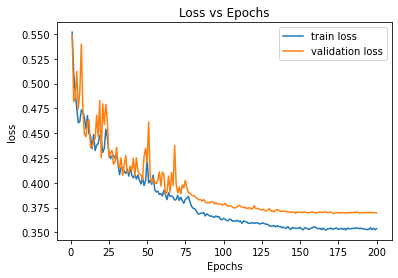

In [20]:
# Training the CNN
model_lenet = LeNetModel().to(device)
optimizer = torch.optim.Adam(model_lenet.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode="max")
loss_train, loss_valid = train(model_lenet, criterion, dataset_train, dataset_valid, optimizer, scheduler, num_epochs)
plot_performance(loss_train, loss_valid)

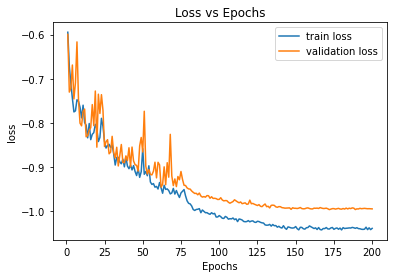

In [21]:
plot_performance(np.log(loss_train), np.log(loss_valid))

#### Performance of the Model with Data Augmentation

In [18]:
# Transformation of the original images (Data Augmentation)
augmentation = T.Compose([
    lambda x : np.around(x * 255).astype("uint8"),
    T.ToPILImage(),
    T.RandomVerticalFlip(0.5),
    T.RandomHorizontalFlip(0.5),
    T.RandomRotation(90),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    T.RandomAdjustSharpness(sharpness_factor=1.5),
    T.ToTensor(),
])

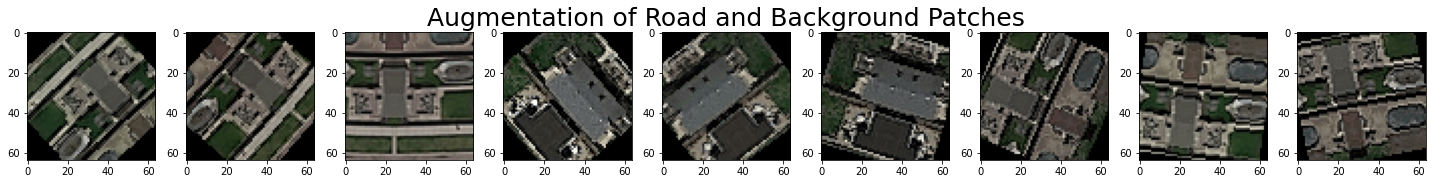

In [18]:
# Visualize possible augmentations for road and background patches from the Training dataset
ind_patches = [10, 5, 9]
fig, ax = plt.subplots(1, 3*len(ind_patches), figsize=(20, 20))
for i in range (3):
    for j in range (len(ind_patches)):
        ax[i + 3*j].imshow(augmentation(img_patches[ind_patches[j]]).permute(1, 2, 0).numpy())

ax[4].set_title("Augmentation of Road and Background Patches", fontdict={'fontsize':25})
plt.tight_layout()

In [19]:
# Augmented Training dataset and validation set
img_train, img_valid, Y_train, Y_valid = train_test_split(img_patches, Y, test_size=0.2)

batch_size = 600
sampler = balanced_sampler(Y_train)
trainsetAugmented = TrainsetCNN(img_train, Y_train, augmentation)
dataset_train = DataLoader(trainsetAugmented, batch_size=batch_size, sampler=sampler)

validset = TrainsetCNN(img_valid, Y_valid)
dataset_valid = DataLoader(validset, batch_size=batch_size, shuffle=True)

Dealing with imbalanced datasets
Background weight: 0.675
Road weight: 1.925


In [20]:
# Training the CNN on the Augmented Dataset
model_lenet = LeNetModel().to(device)
optimizer = torch.optim.Adam(model_lenet.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode="max")
loss_train, loss_valid = train(model_lenet, criterion, dataset_train, dataset_valid, optimizer, scheduler, num_epochs)
plot_performance(loss_train, loss_valid)

Starting training


100%|██████████████████████████████████████████| 84/84 [02:03<00:00,  1.47s/it]


Epoch 1
val accuracy: 0.73489, f1-score: 0.62357



100%|██████████████████████████████████████████| 84/84 [01:57<00:00,  1.40s/it]


Epoch 2
val accuracy: 0.71919, f1-score: 0.61148



100%|██████████████████████████████████████████| 84/84 [01:55<00:00,  1.38s/it]


Epoch 3
val accuracy: 0.81208, f1-score: 0.65341



100%|██████████████████████████████████████████| 84/84 [01:55<00:00,  1.37s/it]


Epoch 4
val accuracy: 0.72689, f1-score: 0.27578



100%|██████████████████████████████████████████| 84/84 [01:54<00:00,  1.36s/it]


Epoch 5
val accuracy: 0.75052, f1-score: 0.51268



100%|██████████████████████████████████████████| 84/84 [01:54<00:00,  1.37s/it]


Epoch 6
val accuracy: 0.71132, f1-score: 0.61846



100%|██████████████████████████████████████████| 84/84 [01:58<00:00,  1.41s/it]


Epoch 7
val accuracy: 0.74722, f1-score: 0.36679



100%|██████████████████████████████████████████| 84/84 [02:01<00:00,  1.44s/it]


Epoch 8
val accuracy: 0.72278, f1-score: 0.62798



100%|██████████████████████████████████████████| 84/84 [02:00<00:00,  1.43s/it]


Epoch 9
val accuracy: 0.75344, f1-score: 0.65906



100%|██████████████████████████████████████████| 84/84 [01:57<00:00,  1.40s/it]


Epoch 10
val accuracy: 0.81237, f1-score: 0.70433



 64%|███████████████████████████               | 54/84 [01:17<00:42,  1.43s/it]


KeyboardInterrupt: 

#### Testing the CNN on one image

Text(0.5, 1.0, 'Test Image 1')

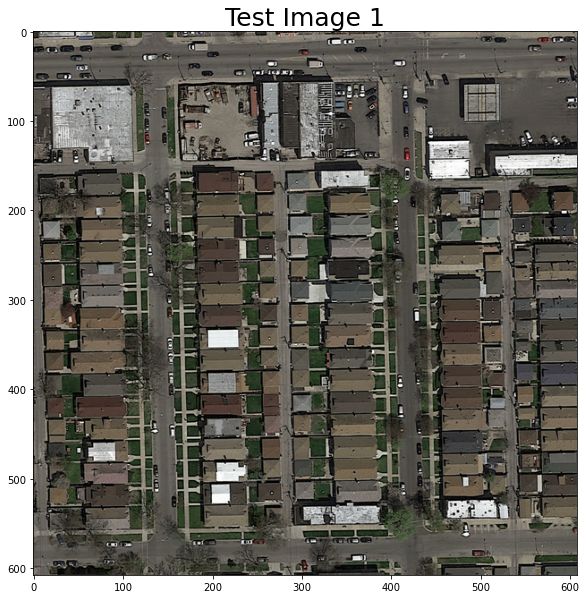

In [20]:
# Load all test images
test_images = list(glob.iglob(image_test + '/*/*.png', recursive=True))

# Extract one test image for visualization
test_1_path = test_images[0]
test_1 = load_image(test_1_path)

# show test image 1
plt.figure(figsize=(10, 10))
plt.imshow(test_1)
plt.title("Test Image 1", fontdict={'fontsize':25})

In [21]:
# Class describing the test dataset
class TestsetCNN(Dataset):
    def __init__(self, x, mean_train, std_train):        
        self.x = x
        self.transformation = T.Compose([T.ToTensor(), T.Normalize(mean_train, std_train)])
        self.length = len(self.x)

    def __getitem__(self, idx):
        return self.transformation(self.x[idx])
        
    def __len__(self):
        return self.length

In [22]:
def predict(model, dataset_test):
    """
    @param model: torch.nn.Module
    @param dataset_test: torch.utils.data.DataLoader
    """
    # Running the prediction for the test set
    model.eval()
    predicted_labels = []
    for batch_x in tqdm(dataset_test):
        predicted_logits = model(batch_x).detach().numpy()
        predicted_labels.append(np.argmax(predicted_logits, 1))
    return np.concatenate(predicted_labels)

In [23]:
# Test set of image patches
patches_test = np.array(img_crop(test_1, patch_size, padding))
dataset_test = torch.utils.data.DataLoader(TestsetCNN(patches_test, mean_img, std_img), batch_size=batch_size, shuffle=False)

# Running the prediction for the test image
Zi = predict(model_lenet, dataset_test)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Zi)[0]
Yn = np.nonzero(Y)[0]
TPR = len(list(set(Yn) & set(Zn))) / float(len(Zi))
print('True positive rate = ' + str(TPR))

# Plot features using predictions to color datapoints
patches_test_2D = extract_img_features(test_1_path)
plt.figure(figsize=(10, 10))
plt.scatter(patches_test_2D[:, 0], patches_test_2D[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)
plt.title("Patch Classification Test Image 1 ({} epochs)".format(num_epochs), fontdict={'fontsize':25})
plt.show()

NameError: name 'model_lenet' is not defined

In [24]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img
    

In [27]:
# Display prediction as an image

w = test_1.shape[0]
h = test_1.shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(test_1, predicted_im)
plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(test_1, predicted_im)

plt.title("Test Image 1 with CNN ({} epochs)".format(num_epochs), fontdict={'fontsize':25})
plt.imshow(new_img)

NameError: name 'test_1' is not defined

## Generating the predictions for the submission

In [22]:
# Building the augmented training set
batch_size = 200
sampler = balanced_sampler(Y)
trainsetAugmented = TrainsetCNN(img_patches, Y, augmentation=None)
dataset_train = DataLoader(trainsetAugmented, batch_size=batch_size, sampler=sampler)

Dealing with imbalanced datasets
Background weight: 0.675
Road weight: 1.930


In [23]:
def train_submissions (model, criterion, dataset_train, optimizer, num_epochs):
    print("Starting training")
    model.train()
    
    loss_train = []
    for epoch in range(num_epochs):
        # Train an epoch
        running_loss = 0.
        f1_train = []
        for batch_x, batch_y in tqdm(dataset_train):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Evaluate the network (forward pass)
            prediction = model(batch_x)
            loss = criterion(prediction, batch_y)
            running_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            aux = prediction.detach().cpu().argmax(1).numpy()
            f1_train.append(f1_score(batch_y.cpu().detach(), aux))

        loss_train.append(running_loss / len(dataset_train))
        f1_epoch = sum(f1_train) / len(f1_train)

        # Printing statistics
        print("Epoch {}".format(epoch + 1))
        print("train f1-score: {:.5f}\n".format(f1_epoch))

    print("Finished")
    return

In [24]:
# hyperparameters
num_epochs = 150
learning_rate = 1e-3

# Criterion to optimize
criterion = torch.nn.CrossEntropyLoss()

In [25]:
# Training the CNN
model_lenet = LeNetModel().to(device)
optimizer = torch.optim.Adam(model_lenet.parameters(), lr=learning_rate)
train_submissions(model_lenet, criterion, dataset_train, optimizer, num_epochs)

Starting training


100%|████████████████████████████████████████| 313/313 [00:28<00:00, 11.09it/s]


Epoch 1
train f1-score: 0.76856



100%|████████████████████████████████████████| 313/313 [00:26<00:00, 11.68it/s]


Epoch 2
train f1-score: 0.80927



100%|████████████████████████████████████████| 313/313 [00:25<00:00, 12.18it/s]


Epoch 3
train f1-score: 0.81658



100%|████████████████████████████████████████| 313/313 [00:26<00:00, 11.99it/s]


Epoch 4
train f1-score: 0.82827



100%|████████████████████████████████████████| 313/313 [00:26<00:00, 11.68it/s]


Epoch 5
train f1-score: 0.83379



100%|████████████████████████████████████████| 313/313 [00:27<00:00, 11.44it/s]


Epoch 6
train f1-score: 0.84316



100%|████████████████████████████████████████| 313/313 [00:27<00:00, 11.28it/s]


Epoch 7
train f1-score: 0.84418



100%|████████████████████████████████████████| 313/313 [00:27<00:00, 11.42it/s]


Epoch 8
train f1-score: 0.84981



100%|████████████████████████████████████████| 313/313 [00:27<00:00, 11.46it/s]


Epoch 9
train f1-score: 0.83987



100%|████████████████████████████████████████| 313/313 [00:27<00:00, 11.34it/s]


Epoch 10
train f1-score: 0.85482



100%|████████████████████████████████████████| 313/313 [00:27<00:00, 11.35it/s]


Epoch 11
train f1-score: 0.85759



100%|████████████████████████████████████████| 313/313 [00:27<00:00, 11.43it/s]


Epoch 12
train f1-score: 0.86498



100%|████████████████████████████████████████| 313/313 [00:27<00:00, 11.38it/s]


Epoch 13
train f1-score: 0.86325



100%|████████████████████████████████████████| 313/313 [00:27<00:00, 11.40it/s]


Epoch 14
train f1-score: 0.86955



100%|████████████████████████████████████████| 313/313 [00:27<00:00, 11.31it/s]


Epoch 15
train f1-score: 0.87034



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.93it/s]


Epoch 16
train f1-score: 0.87483



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 11.02it/s]


Epoch 17
train f1-score: 0.88160



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 11.00it/s]


Epoch 18
train f1-score: 0.87780



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 11.01it/s]


Epoch 19
train f1-score: 0.88195



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.90it/s]


Epoch 20
train f1-score: 0.88395



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 11.03it/s]


Epoch 21
train f1-score: 0.87809



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.98it/s]


Epoch 22
train f1-score: 0.88842



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 11.05it/s]


Epoch 23
train f1-score: 0.89279



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.82it/s]


Epoch 24
train f1-score: 0.89411



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.94it/s]


Epoch 25
train f1-score: 0.89037



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 11.00it/s]


Epoch 26
train f1-score: 0.89032



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.97it/s]


Epoch 27
train f1-score: 0.89299



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.96it/s]


Epoch 28
train f1-score: 0.88270



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.89it/s]


Epoch 29
train f1-score: 0.89792



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.83it/s]


Epoch 30
train f1-score: 0.88963



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.87it/s]


Epoch 31
train f1-score: 0.89312



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.86it/s]


Epoch 32
train f1-score: 0.89446



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.91it/s]


Epoch 33
train f1-score: 0.90234



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.94it/s]


Epoch 34
train f1-score: 0.90268



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.88it/s]


Epoch 35
train f1-score: 0.90679



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.85it/s]


Epoch 36
train f1-score: 0.90519



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.96it/s]


Epoch 37
train f1-score: 0.90354



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.96it/s]


Epoch 38
train f1-score: 0.89632



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.81it/s]


Epoch 39
train f1-score: 0.89942



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.95it/s]


Epoch 40
train f1-score: 0.90379



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.91it/s]


Epoch 41
train f1-score: 0.89973



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.85it/s]


Epoch 42
train f1-score: 0.89896



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.81it/s]


Epoch 43
train f1-score: 0.91120



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.73it/s]


Epoch 44
train f1-score: 0.90585



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.71it/s]


Epoch 45
train f1-score: 0.91334



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.68it/s]


Epoch 46
train f1-score: 0.90806



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.73it/s]


Epoch 47
train f1-score: 0.91702



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.67it/s]


Epoch 48
train f1-score: 0.91511



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.74it/s]


Epoch 49
train f1-score: 0.91210



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.69it/s]


Epoch 50
train f1-score: 0.91864



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.72it/s]


Epoch 51
train f1-score: 0.91996



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.67it/s]


Epoch 52
train f1-score: 0.91568



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.74it/s]


Epoch 53
train f1-score: 0.90915



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.68it/s]


Epoch 54
train f1-score: 0.91881



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.75it/s]


Epoch 55
train f1-score: 0.91881



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.75it/s]


Epoch 56
train f1-score: 0.92219



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.76it/s]


Epoch 57
train f1-score: 0.92274



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.77it/s]


Epoch 58
train f1-score: 0.92156



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.75it/s]


Epoch 59
train f1-score: 0.92412



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.81it/s]


Epoch 60
train f1-score: 0.92744



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.72it/s]


Epoch 61
train f1-score: 0.92841



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.76it/s]


Epoch 62
train f1-score: 0.92659



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.69it/s]


Epoch 63
train f1-score: 0.92178



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.69it/s]


Epoch 64
train f1-score: 0.92420



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.74it/s]


Epoch 65
train f1-score: 0.92727



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.83it/s]


Epoch 66
train f1-score: 0.92825



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.79it/s]


Epoch 67
train f1-score: 0.93069



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.87it/s]


Epoch 68
train f1-score: 0.93485



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.75it/s]


Epoch 69
train f1-score: 0.92957



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.65it/s]


Epoch 70
train f1-score: 0.93142



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.64it/s]


Epoch 71
train f1-score: 0.93327



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.55it/s]


Epoch 72
train f1-score: 0.92929



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.82it/s]


Epoch 73
train f1-score: 0.93204



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.55it/s]


Epoch 74
train f1-score: 0.93893



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.46it/s]


Epoch 75
train f1-score: 0.93426



100%|████████████████████████████████████████| 313/313 [00:30<00:00, 10.36it/s]


Epoch 76
train f1-score: 0.93692



100%|████████████████████████████████████████| 313/313 [00:30<00:00, 10.40it/s]


Epoch 77
train f1-score: 0.93828



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.69it/s]


Epoch 78
train f1-score: 0.93843



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.84it/s]


Epoch 79
train f1-score: 0.94214



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.94it/s]


Epoch 80
train f1-score: 0.93715



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.93it/s]


Epoch 81
train f1-score: 0.94257



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 11.02it/s]


Epoch 82
train f1-score: 0.93382



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.99it/s]


Epoch 83
train f1-score: 0.94018



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.78it/s]


Epoch 84
train f1-score: 0.94414



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.61it/s]


Epoch 85
train f1-score: 0.94486



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.53it/s]


Epoch 86
train f1-score: 0.94666



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.63it/s]


Epoch 87
train f1-score: 0.94275



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.75it/s]


Epoch 88
train f1-score: 0.94166



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.86it/s]


Epoch 89
train f1-score: 0.94521



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.75it/s]


Epoch 90
train f1-score: 0.94402



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.82it/s]


Epoch 91
train f1-score: 0.94471



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 11.03it/s]


Epoch 92
train f1-score: 0.94470



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 11.04it/s]


Epoch 93
train f1-score: 0.94228



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 11.03it/s]


Epoch 94
train f1-score: 0.94510



100%|████████████████████████████████████████| 313/313 [00:31<00:00,  9.85it/s]


Epoch 95
train f1-score: 0.94631



100%|████████████████████████████████████████| 313/313 [00:34<00:00,  9.10it/s]


Epoch 96
train f1-score: 0.94811



100%|████████████████████████████████████████| 313/313 [00:31<00:00,  9.97it/s]


Epoch 97
train f1-score: 0.95045



100%|████████████████████████████████████████| 313/313 [00:30<00:00, 10.26it/s]


Epoch 98
train f1-score: 0.95321



100%|████████████████████████████████████████| 313/313 [00:30<00:00, 10.31it/s]


Epoch 99
train f1-score: 0.95590



100%|████████████████████████████████████████| 313/313 [00:33<00:00,  9.22it/s]


Epoch 100
train f1-score: 0.95066



100%|████████████████████████████████████████| 313/313 [00:31<00:00,  9.99it/s]


Epoch 101
train f1-score: 0.94579



100%|████████████████████████████████████████| 313/313 [00:31<00:00, 10.04it/s]


Epoch 102
train f1-score: 0.95006



100%|████████████████████████████████████████| 313/313 [00:30<00:00, 10.12it/s]


Epoch 103
train f1-score: 0.95496



100%|████████████████████████████████████████| 313/313 [00:32<00:00,  9.77it/s]


Epoch 104
train f1-score: 0.94863



100%|████████████████████████████████████████| 313/313 [00:30<00:00, 10.39it/s]


Epoch 105
train f1-score: 0.95292



100%|████████████████████████████████████████| 313/313 [00:30<00:00, 10.27it/s]


Epoch 106
train f1-score: 0.95302



100%|████████████████████████████████████████| 313/313 [00:33<00:00,  9.31it/s]


Epoch 107
train f1-score: 0.95331



100%|████████████████████████████████████████| 313/313 [00:30<00:00, 10.13it/s]


Epoch 108
train f1-score: 0.94975



100%|████████████████████████████████████████| 313/313 [00:36<00:00,  8.66it/s]


Epoch 109
train f1-score: 0.95220



100%|████████████████████████████████████████| 313/313 [00:31<00:00,  9.91it/s]


Epoch 110
train f1-score: 0.95638



100%|████████████████████████████████████████| 313/313 [00:30<00:00, 10.38it/s]


Epoch 111
train f1-score: 0.94795



100%|████████████████████████████████████████| 313/313 [00:32<00:00,  9.57it/s]


Epoch 112
train f1-score: 0.95132



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.47it/s]


Epoch 113
train f1-score: 0.95323



100%|████████████████████████████████████████| 313/313 [00:31<00:00,  9.93it/s]


Epoch 114
train f1-score: 0.95625



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.68it/s]


Epoch 115
train f1-score: 0.95467



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.70it/s]


Epoch 116
train f1-score: 0.95721



100%|████████████████████████████████████████| 313/313 [00:30<00:00, 10.38it/s]


Epoch 117
train f1-score: 0.95281



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.71it/s]


Epoch 118
train f1-score: 0.95322



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.45it/s]


Epoch 119
train f1-score: 0.95632



100%|████████████████████████████████████████| 313/313 [00:28<00:00, 10.80it/s]


Epoch 120
train f1-score: 0.95684



100%|████████████████████████████████████████| 313/313 [00:29<00:00, 10.79it/s]


Epoch 121
train f1-score: 0.95028



100%|████████████████████████████████████████| 313/313 [00:31<00:00,  9.84it/s]


Epoch 122
train f1-score: 0.94579



100%|████████████████████████████████████████| 313/313 [00:32<00:00,  9.64it/s]


Epoch 123
train f1-score: 0.95056



100%|████████████████████████████████████████| 313/313 [00:32<00:00,  9.73it/s]


Epoch 124
train f1-score: 0.94863



100%|████████████████████████████████████████| 313/313 [00:32<00:00,  9.58it/s]


Epoch 125
train f1-score: 0.95454



100%|████████████████████████████████████████| 313/313 [00:32<00:00,  9.52it/s]


Epoch 126
train f1-score: 0.95564



100%|████████████████████████████████████████| 313/313 [00:32<00:00,  9.55it/s]


Epoch 127
train f1-score: 0.95741



100%|████████████████████████████████████████| 313/313 [00:32<00:00,  9.54it/s]


Epoch 128
train f1-score: 0.95895



100%|████████████████████████████████████████| 313/313 [00:32<00:00,  9.50it/s]


Epoch 129
train f1-score: 0.95052



100%|████████████████████████████████████████| 313/313 [00:32<00:00,  9.75it/s]


Epoch 130
train f1-score: 0.95498



100%|████████████████████████████████████████| 313/313 [00:32<00:00,  9.57it/s]


Epoch 131
train f1-score: 0.95731



100%|████████████████████████████████████████| 313/313 [00:35<00:00,  8.79it/s]


Epoch 132
train f1-score: 0.96054



100%|████████████████████████████████████████| 313/313 [00:32<00:00,  9.54it/s]


Epoch 133
train f1-score: 0.96301



100%|████████████████████████████████████████| 313/313 [00:33<00:00,  9.28it/s]


Epoch 134
train f1-score: 0.95553



100%|████████████████████████████████████████| 313/313 [00:33<00:00,  9.32it/s]


Epoch 135
train f1-score: 0.95856



100%|████████████████████████████████████████| 313/313 [00:32<00:00,  9.51it/s]


Epoch 136
train f1-score: 0.96081



100%|████████████████████████████████████████| 313/313 [00:32<00:00,  9.68it/s]


Epoch 137
train f1-score: 0.95555



100%|████████████████████████████████████████| 313/313 [00:32<00:00,  9.63it/s]


Epoch 138
train f1-score: 0.95823



100%|████████████████████████████████████████| 313/313 [00:32<00:00,  9.68it/s]


Epoch 139
train f1-score: 0.95511



100%|████████████████████████████████████████| 313/313 [00:32<00:00,  9.70it/s]


Epoch 140
train f1-score: 0.95849



100%|████████████████████████████████████████| 313/313 [00:32<00:00,  9.73it/s]


Epoch 141
train f1-score: 0.95656



100%|████████████████████████████████████████| 313/313 [00:32<00:00,  9.69it/s]


Epoch 142
train f1-score: 0.95429



100%|████████████████████████████████████████| 313/313 [00:32<00:00,  9.70it/s]


Epoch 143
train f1-score: 0.96004



100%|████████████████████████████████████████| 313/313 [00:32<00:00,  9.64it/s]


Epoch 144
train f1-score: 0.96196



100%|████████████████████████████████████████| 313/313 [00:32<00:00,  9.68it/s]


Epoch 145
train f1-score: 0.95574



100%|████████████████████████████████████████| 313/313 [00:32<00:00,  9.62it/s]


Epoch 146
train f1-score: 0.95652



100%|████████████████████████████████████████| 313/313 [00:32<00:00,  9.63it/s]


Epoch 147
train f1-score: 0.95416



100%|████████████████████████████████████████| 313/313 [00:34<00:00,  9.19it/s]


Epoch 148
train f1-score: 0.95760



100%|████████████████████████████████████████| 313/313 [00:32<00:00,  9.68it/s]


Epoch 149
train f1-score: 0.95697



100%|████████████████████████████████████████| 313/313 [00:32<00:00,  9.63it/s]

Epoch 150
train f1-score: 0.95839

Finished


In [26]:
# Submissions
def mask_to_submission_strings(model_lenet, image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    model_lenet.eval()
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = np.asarray(mpimg.imread(image_filename))
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    im = np.lib.pad(im, ((padding, padding), (padding, padding), (0, 0)), 'reflect')
    patch_size = 16
    for j in range(padding, imgwidth + padding, patch_size):
        for i in range(padding, imgheight + padding, patch_size):
            patch = im[i - padding:i + patch_size + padding, j - padding:j + patch_size + padding, :]
            patch = T.Compose([T.ToTensor(), T.Normalize(mean_img, std_img)])(patch)
            predict = model_lenet(patch[np.newaxis, :])
            label = np.argmax(predict.detach().numpy(), 1)[0]
            yield("{:03d}_{}_{},{}".format(img_number, j - padding, i - padding, label))


def masks_to_submission(model_lenet, submission_filename, image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in tqdm(image_filenames):
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(model_lenet.cpu(), fn))

test_files = list(glob.iglob(image_test + '/*/*.png', recursive=True))
masks_to_submission(model_lenet, "submission.csv", test_files)

100%|██████████████████████████████████████████| 50/50 [06:37<00:00,  7.95s/it]


In [ ]:
for i in range (24, 632, 16):
    print(i)

## Comparing the Results using a Pretrained U-Net

#### Training dataset used by the ResNet 50

In [ ]:
# Class describing the training set used by the UNet
class TrainsetUNet(Dataset):
    def __init__(self, x, y, augmentation=None):
        self.x = x
        self.y = y
        self.length = len(self.x) # Number of image patches in the dataset
        # The way we define data augmentation in our dataset
        if augmentation:
            self.augmentation = augmentation
        else:
            self.augmentation = T.Compose([T.ToTensor()]) # No Data Augmentation

    def __getitem__(self, idx):
        return self.augmentation(self.x[idx]), self.augmentation(self.y[idx])

    def __len__(self):
        return self.length

In [ ]:
# Trainset and Validation sets
img_train, img_valid, gt_train, gt_valid = train_test_split(imgs, gt_imgs, test_size=0.5)

batch_size = 200
dataset_train = DataLoader(TrainsetUNet(img_train, gt_train), batch_size=batch_size, shuffle=True)
dataset_valid = DataLoader(TrainsetUNet(img_valid, gt_valid), batch_size=batch_size, shuffle=True)

print("Number of images in the training dataset: {}".format(len(img_train)))
print("Number of images in the validation dataset: {}".format(len(img_valid)))

#### Defining the Network U-Net to be used

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

#### Hyperparameters

In [ ]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 5

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00008),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth'):
    model = torch.load('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth', map_location=DEVICE)

In [ ]:
# Training the CNN on the Augmented Dataset
loss_train, loss_valid = train(model, loss, dataset_train, dataset_valid, optimizer, num_epochs)
plot_performance(loss_train, loss_valid)

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(dataset_train)
        valid_logs = valid_epoch.run(dataset_valid)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')

In [28]:
torch.save(model_lenet.state_dict(), "weights")